# Build a Clang

In [32]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
from labm8 import humanize

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import fs, viz

def cache_time(path):
    modified = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    diff = (datetime.datetime.now() - modified).seconds
    return humanize.Duration(diff) + "ago ({})".format(modified)

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

NUM_PROGRAMS = 75000

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

In [37]:
def get_crash_table():
    rows = []
    with Session(commit=False) as s:
        clangs = s.query(CLgenClangResult.clang)\
                    .distinct()\
                    .order_by(CLgenClangResult.clang)

        for clang, in clangs:
            # results for this clang
            q = s.query(CLgenClangResult.id)\
                .filter(CLgenClangResult.clang == clang)\
                .order_by(CLgenClangResult.program_id)

            num_crashes = q.filter(CLgenClangResult.status != 0,
                                   CLgenClangResult.status != 1)\
                            .limit(NUM_PROGRAMS).count()
            num_programs = q.limit(NUM_PROGRAMS).count()
            
            assertions = s.query(CLgenClangAssertion.id)\
                .join(CLgenClangStderr)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang)\
                .distinct()\
                .count()
                
            unreachables = s.query(CLgenClangUnreachable.id)\
                .join(CLgenClangStderr)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang)\
                .distinct()\
                .count()
                
            terminates = s.query(CLgenClangTerminate.id)\
                .join(CLgenClangStderr)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang)\
                .distinct()\
                .count()
                
            unique = assertions + unreachables + terminates

            ratio = num_crashes / num_programs
            if clang == "6.0.0":
                clang = "Trunk"
            
            rows.append([clang, num_programs, num_crashes, ratio, assertions, unreachables, terminates, unique])
    return pd.DataFrame(rows, columns=[
        "Version", 
        "#. Results", 
        "#. Crashes", 
        "Ratio", 
        "#. Assertions",
        "#. Unreachables",
        "#. Terminates",
        "#. Unique",
    ])

crash_table = get_crash_table()
crash_table

Exception during reset or similar
Traceback (most recent call last):
  File "/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/sqlalchemy/pool.py", line 687, in _finalize_fairy
    fairy._reset(pool)
  File "/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/sqlalchemy/pool.py", line 829, in _reset
    pool._dialect.do_rollback(self)
  File "/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/base.py", line 1575, in do_rollback
    dbapi_connection.rollback()
_mysql_exceptions.OperationalError: (2013, 'Lost connection to MySQL server during query')


,Version,#. Results,#. Crashes,Ratio,#. Assertions,#. Unreachables,#. Terminates,#. Unique
0,3.6.2,75000,3196,0.042613,3,2,0,5
1,3.7.1,75000,1370,0.018267,2,2,0,4
2,3.8.1,75000,1347,0.017960,2,1,0,3
3,3.9.1,75000,429,0.005720,2,1,0,3
4,4.0.1,75000,542,0.007227,2,2,0,4
5,5.0.0,75000,96,0.001280,1,1,0,2
6,Trunk,75000,121,0.001613,3,2,0,5


/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


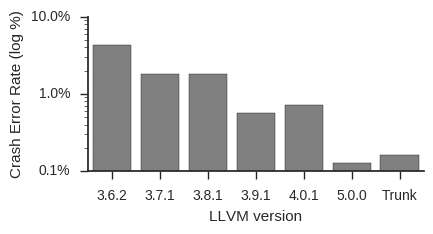

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/clang-crashes.pdf
[master f2a2249] auto: build/img/clang-crashes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.56 KiB | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   f137eb3..f2a2249  master -> master


In [35]:
sns.set(style="ticks")

def plot_crash_rate(*args, **kwargs):
    ax = sns.barplot(x="Version", y='Ratio', data=crash_table, color='gray')

    # X axis
    plt.xlabel("LLVM version")
#    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks

    # Y axis
    plt.ylabel("Crash Error Rate (log %)")
    ax.set_yscale("log", nonposy='clip')
    ax.set_yticklabels(['{:.1f}%'.format(x*100) for x in ax.get_yticks()])
    # plt.ylim((0,None))
    
    # Border
    sns.despine(ax=ax)
    viz.finalise(*args, figsize=(4.5, 2.5), **kwargs)

plot_crash_rate()
    
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_crash_rate(fs.path("~/docs/paper-project_b/build/img/clang-crashes.pdf"))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/clang-crashes.pdf" && git push

In [6]:
sns.set(style="ticks")

def plot_unique_crashes(*args, **kwargs):
    ax = sns.barplot(x="Version", y='#. Unique', data=crash_table, color='gray')

    # X axis
    plt.xlabel("LLVM version\n\n(b)")
    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks

    # Y axis
    plt.ylabel("Distinct Compiler Crashes")
    
    # Border
    sns.despine(ax=ax)

/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


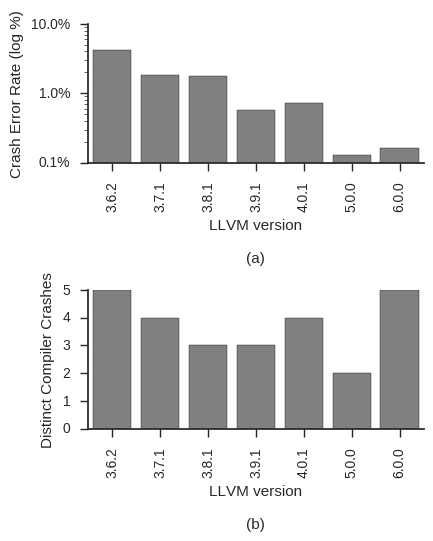

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/clang-crashes.pdf
[master 8846f20] auto: build/img/clang-crashes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 451 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   e29e63c..8846f20  master -> master


In [7]:
def plot_both(*args, **kwargs):
    plt.subplot(2, 1, 1)
    plot_crash_rate()
    plt.subplot(2, 1, 2)
    plot_unique_crashes()

    viz.finalise(*args, **kwargs, figsize=(4.5, 5.5))

In [39]:
from collections import defaultdict

def get_counts_table():
    rows = []
    with Session(commit=False) as s:
        clangs = s.query(CLgenClangResult.clang)\
                    .distinct()\
                    .order_by(CLgenClangResult.clang)
        
        assertions = s.query(CLgenClangAssertion)
        unreachables = s.query(CLgenClangUnreachable)
        
        indexes = []
        for i, assertion in enumerate(assertions):
            indexes.append("Assertion {}".format(i + 1))#assertion.assertion.split(":")[-1])
            hits = []
            
            for clang, in clangs:
                q = s.query(sql.sql.func.count(CLgenClangResult.id))\
                    .join(CLgenClangStderr)\
                    .filter(CLgenClangResult.clang == clang,
                            CLgenClangStderr.assertion_id == assertion.id)\
                    .scalar()
                hits.append(q if q else '')
                
            rows.append(hits)
            
        indexes.append("Unreachable")
        hits = []
        for clang, in clangs:
            q = s.query(sql.sql.func.count(CLgenClangResult.id))\
                .join(CLgenClangStderr)\
                .filter(CLgenClangResult.clang == clang,
                        CLgenClangStderr.unreachable_id != None)\
                .distinct()\
                .scalar()
                        
            hits.append(q)
        
        rows.append(hits)
    
    return pd.DataFrame(rows, columns=["Trunk" if x[0] == "6.0.0" else x[0] for x in clangs], index=indexes)


counts_table = get_counts_table()
counts_table

,3.6.2,3.7.1,3.8.1,3.9.1,4.0.1,5.0.0,Trunk
Assertion 1,2962,1327,1332,414,523,83,97
Assertion 2,,1,1,,,,
Assertion 3,,,,,,,1
Assertion 4,,,,,,,2
Assertion 5,147,,,,,,
Assertion 6,1,,,,,,
Assertion 7,,,,1,1,,
Unreachable,86,42,14,14,18,13,21


In [10]:
from collections import defaultdict

def get_unique_table():
    rows = []
    with Session(commit=False) as s:
        clangs = s.query(CLgenClangResult.clang)\
                    .distinct()\
                    .order_by(CLgenClangResult.clang)
        
        assertions = s.query(CLgenClangAssertion)
        unreachables = s.query(CLgenClangUnreachable)
        
        indexes = []
        for i, assertion in enumerate(assertions):
            indexes.append("Assert.\\ {}".format(i + 1))#assertion.assertion.split(":")[-1])
            hits = []
            
            for clang, in clangs:
                q = s.query(CLgenClangResult.id)\
                    .join(CLgenClangStderr)\
                    .filter(CLgenClangResult.clang == clang,
                            CLgenClangStderr.assertion_id == assertion.id)\
                    .first()

                hits.append("\\xmark" if q else " ")
                
            rows.append(hits)
            
        indexes.append("Unreach.")
        hits = []
        for clang, in clangs:
            q = s.query(CLgenClangStderr.unreachable_id)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang,
                        CLgenClangStderr.unreachable_id != None)\
                .distinct()\
                .count()

            hits.append(q)

        rows.append(hits)
    
    return pd.DataFrame(rows, columns=[x[0] for x in clangs], index=indexes)
            

unique_table = get_unique_table()
unique_table

,3.6.2,3.7.1,3.8.1,3.9.1,4.0.1,5.0.0,6.0.0
Assert.\ 1,\xmark,\xmark,\xmark,\xmark,\xmark,\xmark,\xmark
Assert.\ 2,,\xmark,\xmark,,,,
Assert.\ 3,,,,,,,\xmark
Assert.\ 4,,,,,,,\xmark
Assert.\ 5,\xmark,,,,,,
Assert.\ 6,\xmark,,,,,,
Assert.\ 7,,,,\xmark,\xmark,,
Unreach.,2,2,1,1,2,1,2


In [109]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
unique_table.to_latex(buf=fs.path("~/docs/paper-project_b/build/tab/clang-asserts.tex"), escape=False,
                      column_format="r|ccccccc")
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/clang-asserts.tex" && git push

Current branch master is up to date.
[master 7439cd6] auto: build/tab/clang-asserts.tex
 1 file changed, 14 insertions(+), 13 deletions(-)
 rewrite build/tab/clang-asserts.tex (78%)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 537 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   5254550..7439cd6  master -> master


In [40]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
counts_table.to_latex(buf=fs.path("~/docs/paper-project_b/build/tab/clang-assert-counts.tex"), escape=False,
                      column_format="r|ccccccc")
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/clang-assert-counts.tex" && git push

remote: Counting objects: 93, done
remote: Finding sources: 100% (77/77)
remote: Getting sizes: 100% (67/67)
remote: Compressing objects: 100% (752122/752122)
remote: Total 77 (delta 46), reused 25 (delta 11)
Unpacking objects: 100% (77/77), done.
From https://git.overleaf.com/8608915dsywxshwwjmw
   f2a2249..50a6ad1  master     -> origin/master
First, rewinding head to replay your work on top of it...
Fast-forwarded master to 50a6ad1bfca7e6752f89bc57a31a5675c8f02e91.
[master e53bb5c] auto: build/tab/clang-assert-counts.tex
 1 file changed, 1 insertion(+), 1 deletion(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 449 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   50a6ad1..e53bb5c  master -> master
